# **Practical Lab-10 Dwarakanath Chandra (8856840)**

### **Finding the top 3 folders with the higest number of images** 

In [227]:
import os
def count_images_in_folder(folder_path):
    image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]  # Add other image extensions if needed
    count = 0
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            if any(file.lower().endswith(ext) for ext in image_extensions):
                count += 1
        elif os.path.isdir(os.path.join(folder_path, file)):
            count += count_images_in_folder(os.path.join(folder_path, file))
    return count

def find_top_n_folders_with_max_images(main_folder_path, n=3):
    folder_counts = []
    for folder_name in os.listdir(main_folder_path):
        folder_path = os.path.join(main_folder_path, folder_name)
        if os.path.isdir(folder_path):
            image_count = count_images_in_folder(folder_path)
            folder_counts.append((folder_name, image_count))

    folder_counts.sort(key=lambda x: x[1], reverse=True)
    top_n_folders = folder_counts[:n]
    return top_n_folders

# Example usage:
main_folder = "C:/Users/dwara/OneDrive/Desktop/Ryan/CSCN8010/data/kaggle_birds/train"
top_3_folders = find_top_n_folders_with_max_images(main_folder, n=3)
print(top_3_folders)


[('D-ARNAUDS BARBET', 200), ('HOUSE FINCH', 200), ('RUFOUS TREPE', 200)]


The count of images readjusted to increase the validation dataset.

### **Feature extraction with a pretrained model**

In [228]:
# Installing the required packages

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.utils import to_categorical

### **Generating Augmented Dataset**

In [229]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import numpy as np

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  # Flip images horizontally
        layers.RandomRotation(0.1),       # Rotate images by up to 0.1 radians
        layers.RandomZoom(0.2),           # Zoom in/out randomly by up to 20%
        layers.RandomContrast(0.2),       # Apply random contrast adjustment
        layers.RandomBrightness(0.2),     # Apply random brightness adjustment
        layers.RandomTranslation(0.2, 0.2) # Apply random translation (horizontal and vertical)
    ]
)

data_folder = pathlib.Path("C:/Users/dwara/OneDrive/Desktop/Ryan/CSCN8010/data/kaggle_birds")

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_folder / "valid",
    image_size=(180, 180),
    batch_size=32)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

# Apply data augmentation to datasets

augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

augmented_validation_dataset = validation_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

augmented_test_dataset = test_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

# Convert labels to one-hot encoded categorical

num_classes = len(train_dataset.class_names)
augmented_train_dataset = augmented_train_dataset.map(
    lambda x, y: (x, tf.one_hot(y, depth=num_classes))
)

augmented_validation_dataset = augmented_validation_dataset.map(
    lambda x, y: (x, tf.one_hot(y, depth=num_classes))
)

augmented_test_dataset = augmented_test_dataset.map(
    lambda x, y: (x, tf.one_hot(y, depth=num_classes))
)

# Convert one-hot encoded labels to integer labels

augmented_train_dataset = augmented_train_dataset.map(
    lambda x, y: (x, tf.argmax(y, axis=-1))
)

augmented_validation_dataset = augmented_validation_dataset.map(
    lambda x, y: (x, tf.argmax(y, axis=-1))
)

augmented_test_dataset = augmented_test_dataset.map(
    lambda x, y: (x, tf.argmax(y, axis=-1))
)

Found 600 files belonging to 3 classes.


Found 88 files belonging to 3 classes.
Found 86 files belonging to 3 classes.


### **Extracting the Preprocessed features and labels**

In [230]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(augmented_train_dataset)
val_features, val_labels =  get_features_and_labels(augmented_validation_dataset)
test_features, test_labels =  get_features_and_labels(augmented_test_dataset)

1/1 [==============================] - 1s 1s/step


### **Defining the VGG16 Pre-train Convolutional Base and Fine Tuning**

In [231]:
# Define the VGG16 model with pre-trained weights
conv_base = keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(180, 180, 3)
)

# Mark the last 4 layers of VGG16 as trainable
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### **Defining and Training the Densely Connected Classifier**

In [232]:
# Define and train the classification model on top of VGG16
model = keras.Sequential([
    keras.layers.Input(shape=train_features.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

### **Fitting the Model**

In [233]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=50,  # You can adjust the number of epochs
    batch_size=32,
    validation_data=(val_features, val_labels),
    callbacks = callbacks
)

Epoch 1/50
19/19 [==============================] - 1s 49ms/step - loss: 3.9157 - accuracy: 0.8733 - val_loss: 1.6467 - val_accuracy: 0.9432
Epoch 2/50
19/19 [==============================] - 1s 38ms/step - loss: 0.7813 - accuracy: 0.9767 - val_loss: 1.8698 - val_accuracy: 0.9545
Epoch 3/50
19/19 [==============================] - 1s 38ms/step - loss: 0.5754 - accuracy: 0.9850 - val_loss: 1.7579 - val_accuracy: 0.9318
Epoch 4/50
19/19 [==============================] - 1s 39ms/step - loss: 0.3400 - accuracy: 0.9833 - val_loss: 2.1053 - val_accuracy: 0.9432
Epoch 5/50
19/19 [==============================] - 1s 42ms/step - loss: 0.5404 - accuracy: 0.9867 - val_loss: 1.1207 - val_accuracy: 0.9545
Epoch 6/50
19/19 [==============================] - 1s 41ms/step - loss: 0.5988 - accuracy: 0.9850 - val_loss: 0.3307 - val_accuracy: 0.9886
Epoch 7/50
19/19 [==============================] - 1s 39ms/step - loss: 0.1263 - accuracy: 0.9933 - val_loss: 2.0200 - val_accuracy: 0.9659
Epoch 8/50
19

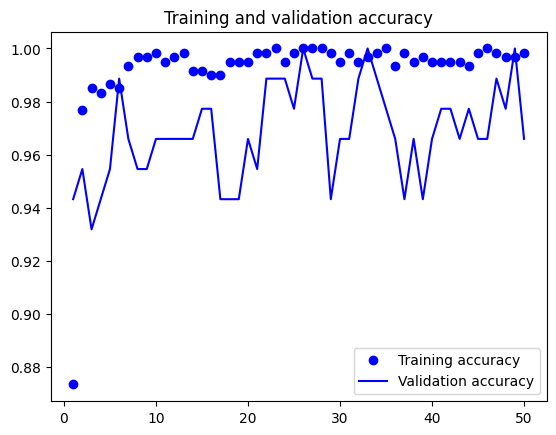

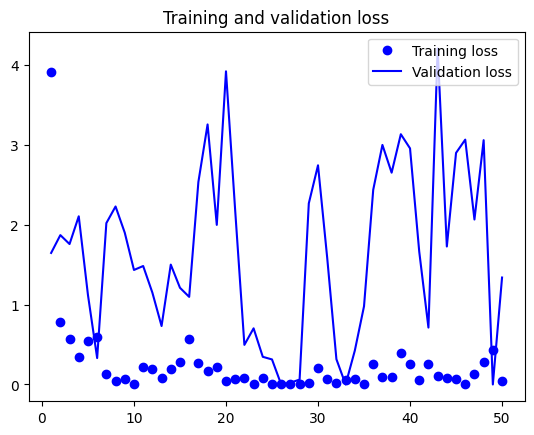

In [234]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")

plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Evaluating the Model Performance on the Test Dataset**

3/3 [==============================] - 0s 4ms/step
Test Accuracy: 0.9534883720930233
Classification Report:
                   precision    recall  f1-score   support

D-ARNAUDS BARBET       0.87      0.95      0.91        21
     HOUSE FINCH       0.96      0.93      0.95        29
    RUFOUS TREPE       1.00      0.97      0.99        36

        accuracy                           0.95        86
       macro avg       0.94      0.95      0.95        86
    weighted avg       0.96      0.95      0.95        86



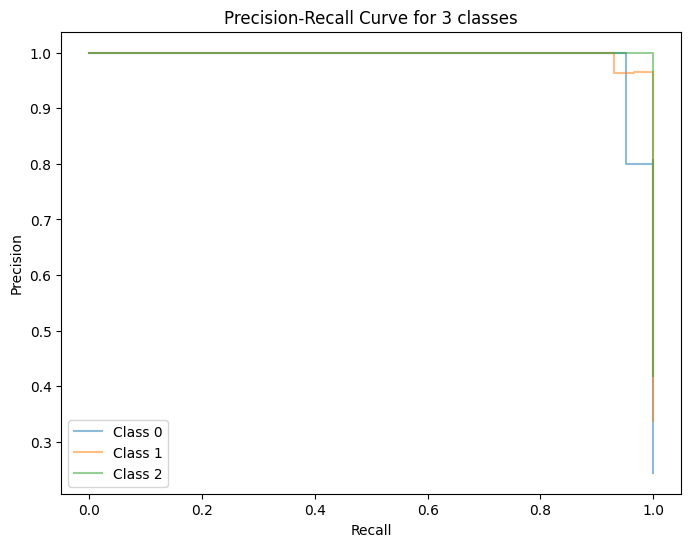

Confusion Matrix:
[[20  1  0]
 [ 2 27  0]
 [ 1  0 35]]
Macro Precision: 0.9446169772256728
Macro Recall: 0.9518792191205985
Macro F1-Score: 0.9474582743670957
Class-wise AUC:
Class 0: AUC = 0.95
Class 1: AUC = 0.97
Class 2: AUC = 1.00


In [258]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming you have predictions for the validation set
test_predictions = model.predict(test_features)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_classes)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

# Confusion Matrix
confusion = confusion_matrix(test_labels, test_predictions_classes)

# Calculate classification report
class_report = classification_report(test_labels, test_predictions_classes, target_names=train_dataset.class_names)

# Print classification report
print("Classification Report:\n", class_report)

# Precision, Recall, and F1-Score (using 'macro' average)
precision_macro = precision_score(test_labels, test_predictions_classes, average='macro')
recall_macro = recall_score(test_labels, test_predictions_classes, average='macro')
f1_macro = f1_score(test_labels, test_predictions_classes, average='macro')

# Precision-Recall Curve and AUC
precision_curve = dict()
recall_curve = dict()
pr_auc = dict()

for class_idx in range(3):
    precision_curve[class_idx], recall_curve[class_idx], _ = precision_recall_curve(
        test_labels == class_idx, test_predictions[:, class_idx])  # Use test_labels and test_predictions
    pr_auc[class_idx] = auc(recall_curve[class_idx], precision_curve[class_idx])


# Plot Precision-Recall Curves
plt.figure(figsize=(8, 6))
for class_idx in range(num_classes):
    plt.step(recall_curve[class_idx], precision_curve[class_idx], alpha=0.5, label=f'Class {class_idx}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for 3 classes')
plt.legend(loc='best')
plt.show()

# Print Metrics
print("Confusion Matrix:")
print(confusion)
print("Macro Precision:", precision_macro)
print("Macro Recall:", recall_macro)
print("Macro F1-Score:", f1_macro)
print("Class-wise AUC:")
for class_idx in range(num_classes):
    print(f"Class {class_idx}: AUC = {pr_auc[class_idx]:.2f}")

### **Exploring the Misclassified Examples**

True class: D-ARNAUDS BARBET, Predicted class: HOUSE FINCH
Predicted probabilities: [8.162652e-34 1.000000e+00 0.000000e+00]


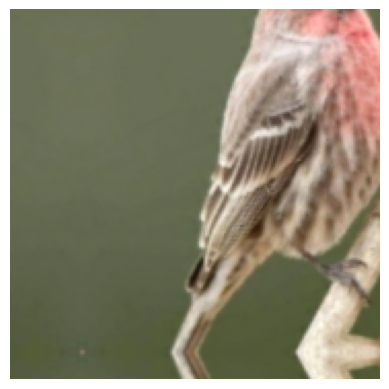

True class: RUFOUS TREPE, Predicted class: D-ARNAUDS BARBET
Predicted probabilities: [1.0000000e+00 0.0000000e+00 1.2659374e-08]


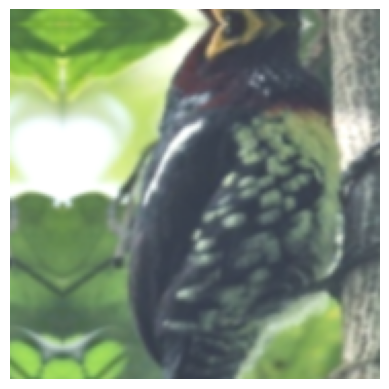

True class: HOUSE FINCH, Predicted class: D-ARNAUDS BARBET
Predicted probabilities: [9.9997663e-01 2.3319466e-05 0.0000000e+00]


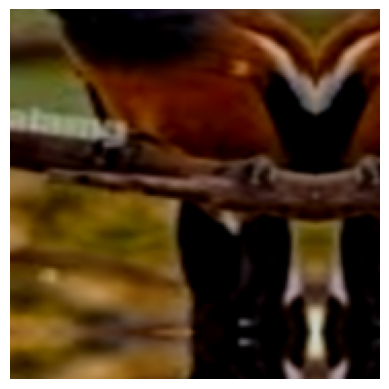

True class: HOUSE FINCH, Predicted class: D-ARNAUDS BARBET
Predicted probabilities: [1.0000000e+00 0.0000000e+00 2.7437312e-31]


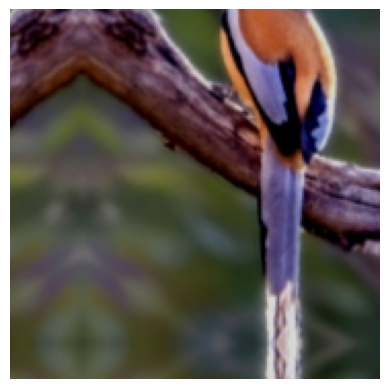

In [259]:
# Find misclassified examples
misclassified_indices = np.where(test_labels != test_predictions_classes)[0]

# Display a few misclassified examples along with their predicted probabilities
num_examples_to_display = 5

for idx in misclassified_indices[:num_examples_to_display]:
    true_class = test_labels[idx]
    predicted_class = test_predictions_classes[idx]
    predicted_probabilities = test_predictions[idx]
    
    print(f"True class: {train_dataset.class_names[true_class]}, Predicted class: {train_dataset.class_names[predicted_class]}")
    print(f"Predicted probabilities: {predicted_probabilities}")
    
    # Display the image if available
    if 'augmented_test_dataset' in globals():
        image, _ = augmented_test_dataset.unbatch().skip(idx).take(1).as_numpy_iterator().next()
        plt.imshow(image.astype('uint8'))
        plt.axis('off')
        plt.show()

    print("="*40)